### **Fontes de pesquisa:**
> **GitHub** 
- Criando Previsões de Preços para 5 dias Adiante: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Criando%20Previso%CC%83es%20de%20Prec%CC%A7os%20para%205%20dias%20Adiante.ipynb
- Criando Previsões de Séries Temporais: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Princi%CC%81pios%20Ba%CC%81sicos%20para%20Prever%20Se%CC%81ries%20Temporais.ipynb

> **YouTube**
- Prevendo Dados com Janelas Deslizantes usando Python: https://www.youtube.com/watch?v=J_ak48BA4RM&t=204s
- Prevendo Vendas com ARIMA - Passo a Passo com Python: https://www.youtube.com/watch?v=v7rZpT8NCbk&t=351s
- Séries temporais com Python: https://www.youtube.com/watch?v=1m9u10eJ3Mk&t=1824s

> **Kaggle** 
- Time Series For beginners with ARIMA: https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima
- Bitcoin Price. Prediction by ARIMA: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima
- ARIMA Model for Time Series Forecasting: https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting
- Everything you can do with a time series: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- AR, ARIMA, LSTM: https://www.kaggle.com/bogdanbaraban/ar-arima-lstm

> **Artigos** 
- Dicas para criar um modelo de previsão de séries temporais: https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
- Identificação de um modelo ARIMA(p,d,q): https://www.midomenech.com.br/identificacao-de-um-modelo-arimapdq/
- Take Time-Series a Level-Up with Walk-Forward Validation: https://sarit-maitra.medium.com/take-time-series-a-level-up-with-walk-forward-validation-217c33114f68
- Forecasting with ARIMA Using Python: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
- A Guide to Time Series Forecasting with ARIMA in Python 3: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-parameter-selection-for-the-arima-time-series-model
- ARIMA Model – Complete Guide to Time Series Forecasting in Python: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Métodos de previsão de séries temporais em python e R: https://datapeaker.com/big-data/lenguajes-de-ciencia-de-datos-en-2020/

In [ ]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(365).mean() #media movel
    rolstd = timeseries.rolling(365).std() #desvio movel

    #Plot rolling statistics:
    fig = plt.subplots(figsize=(10,5))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red', label='Médias Móveis')
    std = plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Teste de estacionariedade da velocidade do vento - Macau')
    plt.ylabel("Velocidade m/s²")
    plt.xlabel("Periodo Observado")
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Resultados do teste de Dickey-Fuller')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

def ehEstacionaria(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    
    if(dfoutput['Estatística do teste'] < dfoutput['Valor crítico (5%)'] and dfoutput['p-value'] < 0.05):
        print('É estacionária.')
    else:
        print('Não é estacionária.')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df.Data = pd.to_datetime(df.Data)

# Tranformando a coluna "Data" em index
df.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


Text(0.5, 0, 'Periodo Observado')

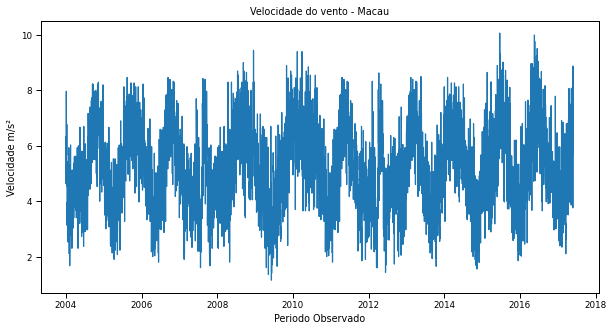

In [ ]:
fig = plt.subplots(figsize=(10,5))
plt.plot(df.Velocidade)
plt.title("Velocidade do vento - Macau")
plt.ylabel("Velocidade m/s²")
plt.xlabel("Periodo Observado")

NOTA: Este plot pode ser utilizado no inicio da definição da modegam dos modelos para representar quais são as variáveis que serão utilizdas na etapa de previsão

<Figure size 576x288 with 0 Axes>

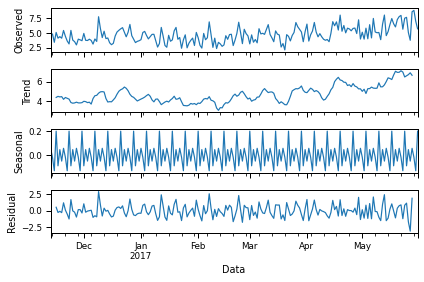

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(df.Velocidade[4700:])
fig = plt.figure(figsize=(8, 4))  
fig = resultado.plot()

### Análise de séries temporais

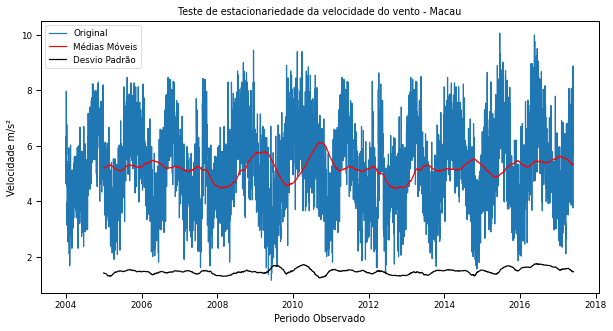

Resultados do teste de Dickey-Fuller
Estatística do teste                      -5.147908
p-value                                    0.000011
O critério de informação maximizado       30.000000
Número de observações usadas            4869.000000
Valor crítico (1%)                        -3.431694
Valor crítico (5%)                        -2.862134
Valor crítico (10%)                       -2.567086
dtype: float64


In [ ]:
adf_test(df.Velocidade)

NOTA: 
- De acordo com o teste de estácionáriedade, podemos perceber q o teste o teste estatístico é maior que os três valores críticos apresentados como 1%, 5%, 10%, além disso, p-value próximo do zero, ou seja, abaixo dos 5%, podendo então rejeitar a hipótese nula de que a série não seja estácionária.

In [ ]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Velocidade do vento em Macau')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição da Velocidade')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Resultados do teste de Dickey-Fuller:
Teste Statistico            -5.1479
Valor-P                      0.0000
Lags Usados                 30.0000
Números de Observações    4869.0000
Valores Críticos (1%)       -3.4317
Valores Críticos (5%)       -2.8621
Valores Críticos (10%)      -2.5671
dtype: float64


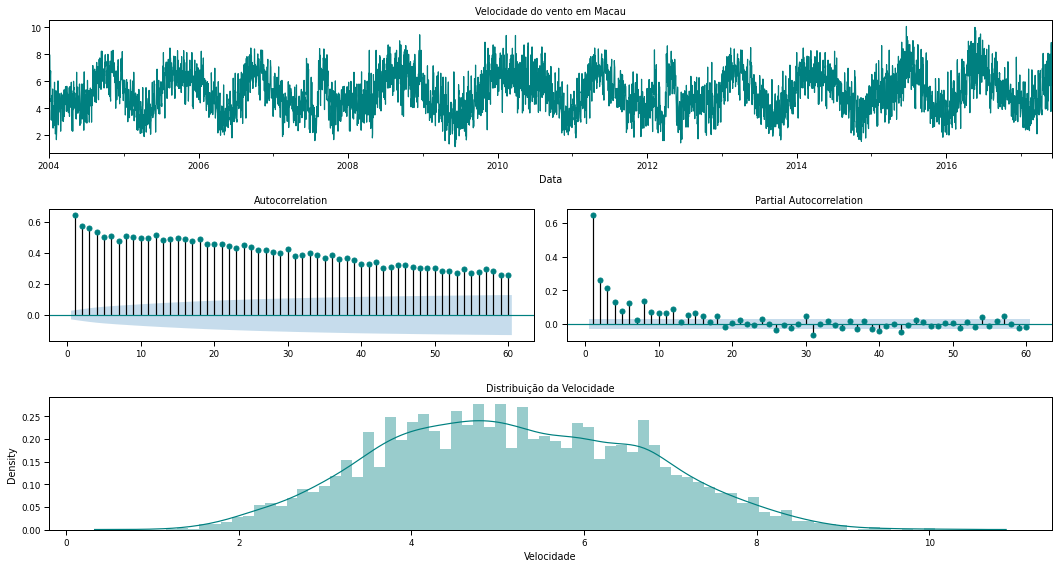

In [ ]:
checar_estacionariedade(df.Velocidade, lags_plots=60)

> Diferentes níveis de diferenciação

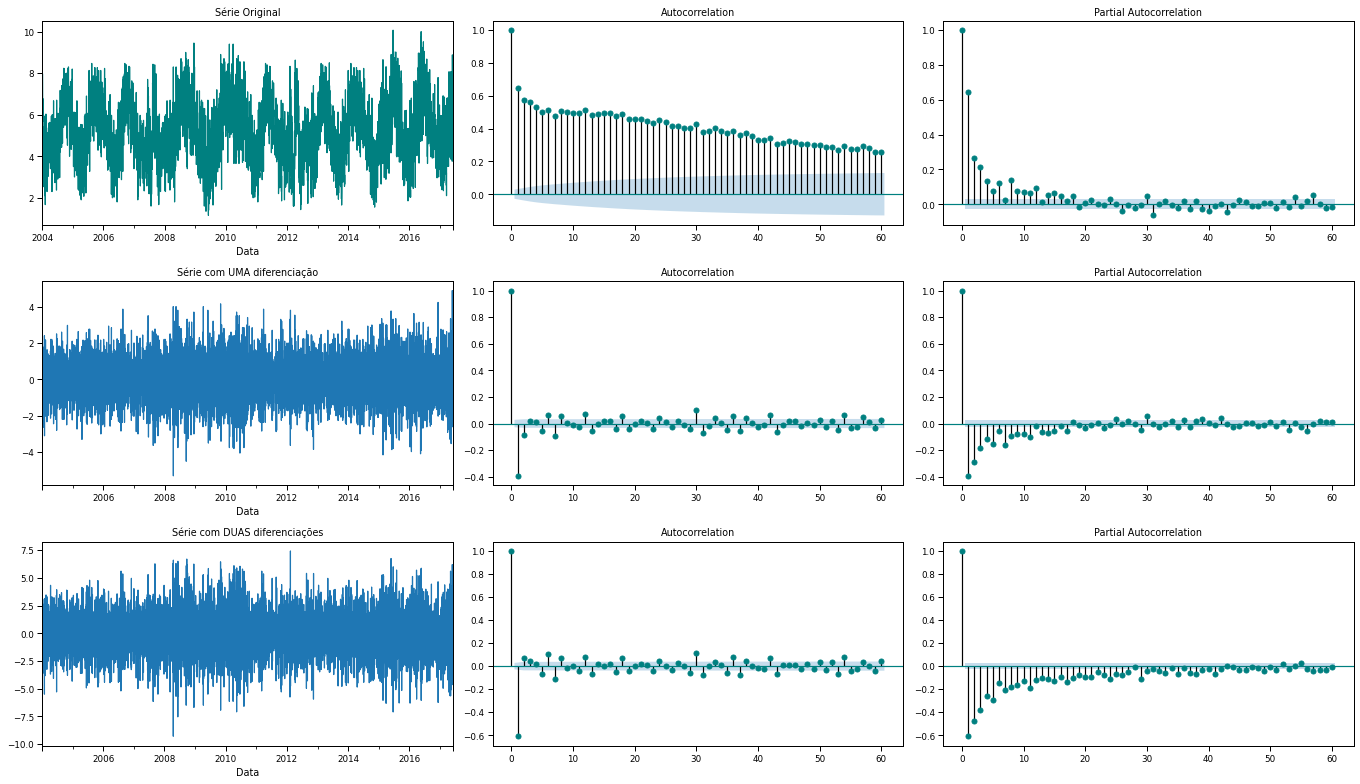

In [ ]:
fig = plt.figure(figsize=(19,11))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1))
ax3 = plt.subplot2grid((3, 3), (0, 2))
ax4 = plt.subplot2grid((3, 3), (1, 0))
ax5 = plt.subplot2grid((3, 3), (1, 1))
ax6 = plt.subplot2grid((3, 3), (1, 2))
ax7 = plt.subplot2grid((3, 3), (2, 0))
ax8 = plt.subplot2grid((3, 3), (2, 1))
ax9 = plt.subplot2grid((3, 3), (2, 2))

# Série Original
df.Velocidade.plot(ax=ax1, title='Série Original', color='teal')
plot_acf(df.Velocidade, lags=60, color='teal',ax=ax2)
plot_pacf(df.Velocidade, lags=60, method='ols', color='teal',ax=ax3);

# Série com UMA diferenciação
df.Velocidade.diff().dropna().plot(ax=ax4, title='Série com UMA diferenciação')
plot_acf(df.Velocidade.diff().dropna(), lags=60, color='teal',ax=ax5)
plot_pacf(df.Velocidade.diff().dropna(), lags=60, method='ols', color='teal',ax=ax6);

# Série com UMA diferenciação
df.Velocidade.diff().diff().dropna().plot(ax=ax7, title='Série com DUAS diferenciações')
plot_acf(df.Velocidade.diff().diff().dropna(), lags=60, color='teal',ax=ax8)
plot_pacf(df.Velocidade.diff().diff().dropna(), lags=60, method='ols', color='teal',ax=ax9);

plt.tight_layout()

### Separação treino e teste

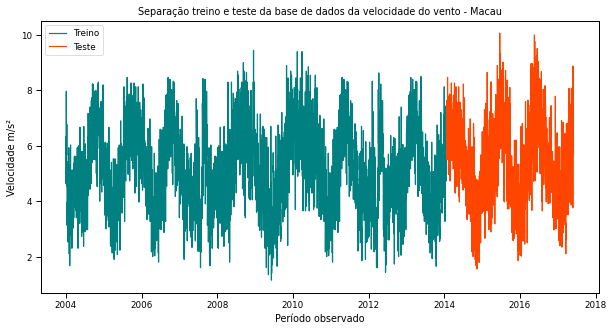

In [ ]:
size = int(len(df.Velocidade) *  0.75)
train = df.Velocidade[:size]
test = df.Velocidade[size:]

plt.figure(figsize=(10,5))
plt.title('Separação treino e teste da base de dados da velocidade do vento - Macau')
plt.plot(train, color='teal')
plt.plot(test, color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Período observado')
plt.ylabel('Velocidade m/s²')
plt.show()

## Criando o modelo

Auto ARIMA: (9,0,7)
- Autorregressão: 9
- Diferenciação: 0
- Médias móveis: 7

Conforme podemos observar, tanto o teste estatístico, quanto o algoritmo que define a ordem do modelo que vamos utilizar, informam que não há necessidade de atribuir diferenciações na série observada, nesse caso, não é necessário a série possar por transformações, visto que ela ja é estacionária

### **Previsão - Dentro da Amostra**

In [ ]:
def predict_data(data, params):
    model = ARIMA(data, order=params)
    model_fit = model.fit(disp=0)
    if params[1] == 0:
        pred = model_fit.predict()
        orig = data
    else:
        pred = model_fit.predict(typ='levels')
        orig = data[params[1]:]
    return orig, pred, model_fit

In [ ]:
def plot_predict_data(orig, pred, start, end):
    plt.plot(orig[start:end],label='Original')
    plt.plot(pred[start:end],'--',label='Previsão')
    plt.title("Previsão dentro da amostra da velocidade do vento - Macau")
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(pred.values, orig.values)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE: " + str(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: " + str(mean_absolute_percentage_error(pred.values, orig.values)))

> ORDER (9,0,7) => RECOMENDADO PELO ALGORITMO

In [ ]:
original,predict,model_fit = predict_data(df.Velocidade,(9,0,7))

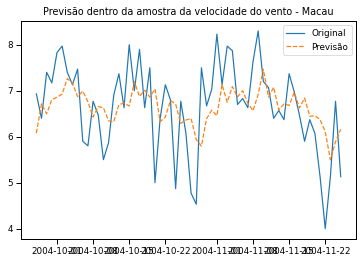

MSE: 1.0411187206742532
RMSE: 1.0203522532313305
MAE: 0.8072952384533476
MAPE: 0.16275722094627434


In [ ]:
plot_predict_data(original,predict,270,330)

NOTA: Essa previsão está sendo feita utilizando o **"predict"** do arima para realizar a predição dentro da amostra com base nos parametros (9,0,7), recomendado pelo algoritmo de automatização da busca por parametros, nesse caso, treinando o modelo e comparando o resultado na propria base treinada

> ORDER (3,0,2) => RECOMENDADO PELO AUTO ARIMA

In [ ]:
original_aa,predict_aa,model_fit_aa = predict_data(df.Velocidade,(3,0,2))

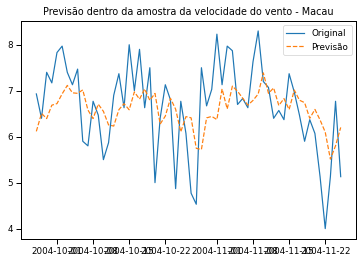

MSE: 1.0711202697590914
RMSE: 1.0349494044440488
MAE: 0.8230573884902106
MAPE: 0.16564048454685124


In [ ]:
plot_predict_data(original_aa,predict_aa,270,330)

> TESTANDO OUTROS MODELOS

In [ ]:
t_orig,t_pred,t_model = predict_data(df.Velocidade,(1,0,0))

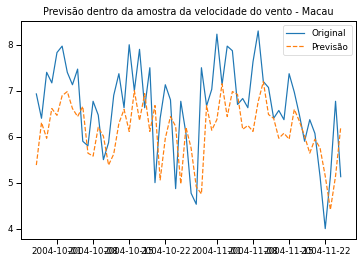

MSE: 1.3070751002515195
RMSE: 1.1432738518183294
MAE: 0.9130968048909924
MAPE: 0.18158259492704357


In [ ]:
plot_predict_data(t_orig,t_pred,270,330)

> Previsão in-of-sample + 14 passos a frente **=> ORDER (9,0,7)**

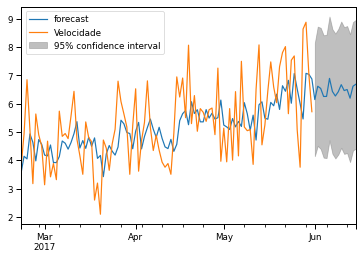

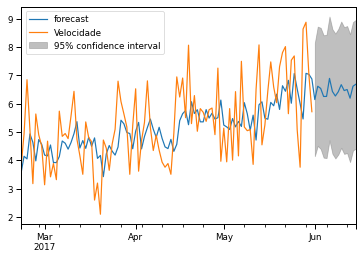

In [ ]:
model_fit.plot_predict(4800,4914,alpha=0.05)

### **Previsão - Fora da Amostra**

> Separação treino e teste

Etapa do pré-processamento dos dados que consiste em sepearar a base de dados em duas em treinamenento e teste, sendo possível treinar o modelo definido com a base de treino e validar os resultados obtidos com a base de teste

In [ ]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) - set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [ ]:
train, test = split_dataset(df.Velocidade, 4, True)


BASE DE TREINO
 Data
2017-05-23    5.65
2017-05-24    7.54
2017-05-25    7.69
2017-05-26    5.08
2017-05-27    3.76
Name: Velocidade, dtype: float64

BASE DE TESTE
 Data
2017-05-28    8.64
2017-05-29    8.88
2017-05-30    7.00
2017-05-31    5.72
Name: Velocidade, dtype: float64


> Previsão de 1 passo a frente - **FORECAST**

In [ ]:
# Modelo (9,0,7) => Pesquisa em grade
model = ARIMA(train, order=(9,0,7))
arima_model = model.fit(disp=0)
arima_model.forecast()[0]

array([5.35527656])

In [ ]:
# Modelo (3,0,2) => Auto-Arima
model_aa = ARIMA(train, order=(3,0,2))
arima_model_aa = model_aa.fit(disp=0)
arima_model_aa.forecast()[0]

array([5.32794642])

In [ ]:
# Modelo (1,0,0)
model_test = ARIMA(train, order=(1,0,0))
arima_model_test = model_test.fit(disp=0)
arima_model_test.forecast()[0]

array([4.25459278])

> Previsão de VARIOS passo a frente - **FORECAST**

In [ ]:
train, test = split_dataset(df.Velocidade, 14, False)

BASE DE TREINO:  4886
BASE DE TESTE:   14


In [ ]:
model = ARIMA(train, order=(9,0,7))
arima_model_nSteps = model.fit(disp=0)
forecast = arima_model.forecast(14)[0]
forecast

array([5.35527656, 5.77051197, 5.66831962, 6.09507189, 5.87423013,
       6.25354655, 6.22750638, 6.20551905, 6.04519543, 6.34206513,
       5.96306607, 6.18494645, 6.10807326, 6.0859947 ])

In [ ]:
from pandas.core.frame import DataFrame
dataset = DataFrame(test)
dataset['previsao'] = forecast
dataset.dropna(inplace=True)
dataset.head()

,Velocidade,previsao
Data,,
2017-05-18,6.59,5.355277
2017-05-19,6.04,5.770512
2017-05-20,7.31,5.668320
2017-05-21,7.81,6.095072
2017-05-22,8.02,5.874230


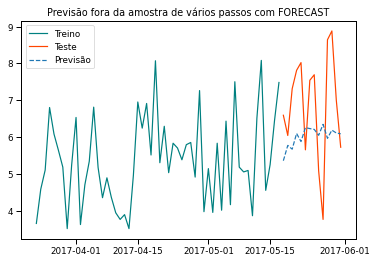

MSE: 2.7918296793683566
RMSE: 1.6708769192757307
MAE: 1.470305744648197
MAPE: 0.2441175476766999


In [ ]:
plt.plot(train[4830:],color='teal',label='Treino')
plt.plot(dataset['Velocidade'],color='orangered',label='Teste')
plt.plot(dataset['previsao'],'--',label='Previsão')
plt.title("Previsão fora da amostra de vários passos com FORECAST")
plt.legend()
plt.show()
print("MSE: " + str(mean_squared_error(dataset['previsao'].values, dataset['Velocidade'].values)))
print("RMSE: " + str(np.sqrt(mean_squared_error(dataset['previsao'].values, dataset['Velocidade'].values))))
print("MAE: " + str(mean_absolute_error(dataset['previsao'].values, dataset['Velocidade'].values)))
print("MAPE: " + str(mean_absolute_percentage_error(dataset['previsao'].values, dataset['Velocidade'].values)))

> Previsão de VARIOS passos a frente - **ALGORITMO**

Algoritmo de treinamento e validação que consiste em treinar o modelo com a base de treino e validar o resultado obtido fora da amostra com o primeiro valor da base de teste, com isso, o valor real da base de teste é adicionado a base de treino e o processo é repetido pela quantida de passos que foi especificado no algoritmo

OBS:
- Se for utilizado um modelo de ordem (1,0,0), ou seja, apenas autorregressão, a previsão não ocorre fora da amostra e sim dentro, nesse caso, o "arimaResults" deveria devolver um valor próximo ao primeiro valor da base de teste, pensando em 1 passo a frente, porem ele devolve um valor que se aproxima do ultimo valor da base de treino.
- Se esse processo utilizando um modelo de ordem (1,0,0) for utilizado no algoritmo de treinamento e validação, o resultado será sempre um atraso do valor real em relação ao previsto, com isso, a visualização do comparativo mostra que o resultado do valor predito acompanha o valor real com um pequeno atraso, porém as métricas de erro devolve um valor muito alto.
-  Utilizando um modelo de ordem (9,0,7), este recomendado pelo algoritmo responsável por automatizar o ajuste dos parametros do modelo, e fazendo uso do mesmo algoritmo de treinamento e validação, podemos perceber que a visualização do comparativo dos valores preditos, tem um pouco de dificuldade de acompanhar as curvas de crescimento e descrecimento dos valores reais, contanto, as métricas de erro devolve um resultado melhor em relação ao modelo de ordem (1,0,0).

In [ ]:
from pandas.core.frame import DataFrame
import warnings
from math import sqrt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def prediction(dataset, params, steps):
    # separa os dados em treino e teste
    x = dataset
    size = int(len(x) - steps)
    train, test = x[0:size], x[size:len(x)]

    prediction = []
    confM=[]
    confm=[]
    history = [x for x in train]
    for t in test.values:
        model = ARIMA(history, order=params).fit(disp=0)
        y,err,ci = model.forecast(steps=len(test), alpha=0.05)
        confm.append(ci[0][0])
        confM.append(ci[0][1])
        prediction.append(y[0])
        history.append(t)
    test_ = DataFrame(test)
    test_['predictions_wf'] = prediction
    # test_ = DataFrame(test[0:len(test)-1])
    # test_['predictions_wf'] = prediction[1:]
    print(test_)
    return test_, confm, confM

In [ ]:
order = (9,0,7)
test_,ci_M,ci_m = prediction(train, order, 7)

            Velocidade  predictions_wf
Data                                  
2017-05-21        7.81        6.541259
2017-05-22        8.02        6.403854
2017-05-23        5.65        6.888168
2017-05-24        7.54        5.860839
2017-05-25        7.69        6.904083
2017-05-26        5.08        6.475816
2017-05-27        3.76        6.104768


> Plotando os resultados

In [ ]:
def plot_prediction(train, test_, ci_m, ci_M, start):
    error = sqrt(mean_squared_error(test_.Velocidade, test_.predictions_wf))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train[start:], label='Treino', color="teal")
    ax.plot(test_.Velocidade, label='Teste',color="orangered")
    ax.plot(test_.predictions_wf, '--,m', label='Previsão')
    ax.fill_between(test_.predictions_wf.index,
                    ci_m,
                    ci_M, color='b', alpha=.15, label='conf. 95%')
    ax.set_title("Previsão da velocidade do vento - Macau")
    ax.set_xlabel('Data')
    ax.set_ylabel('Velocidade')
    plt.suptitle(["RMSE:", round(error,3)])
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_['Velocidade'])))
    print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_['Velocidade']))))
    print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_['Velocidade'])))
    print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_['Velocidade'])))

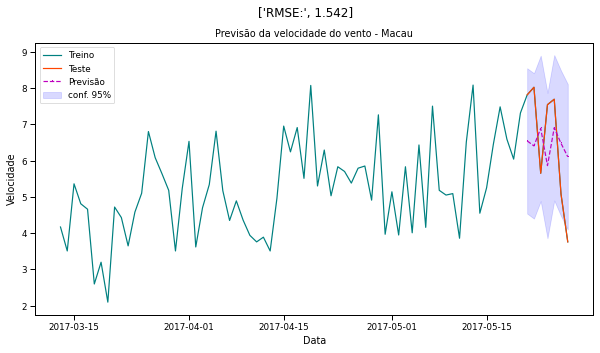

MSE: 2.3768824448596106
RMSE: 1.5417141255302849
MAE: 1.4755309664694545
MAPE: 0.23229330050654054


In [ ]:
plot_prediction(train, test_, ci_m, ci_M, 4820)

> Analisando as métricas de erro

In [ ]:
print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_['Velocidade'])))
print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_['Velocidade']))))
print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_['Velocidade'])))
print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_['Velocidade'])))

MSE: 2.3768824448596106
RMSE: 1.5417141255302849
MAE: 1.4755309664694545
MAPE: 0.23229330050654054


### Testanto outros modelos
> ORDER(3,0,2) -> Auto-Arima

In [ ]:
order = (3,0,2)
r_test,conf_m, conf_M = prediction(df['Velocidade'],order,7)

            Velocidade  predictions_wf
Data                                  
2017-05-25        7.69        6.848737
2017-05-26        5.08        6.700884
2017-05-27        3.76        6.187890
2017-05-28        8.64        5.327946
2017-05-29        8.88        7.043775
2017-05-30        7.00        7.087281
2017-05-31        5.72        6.844288


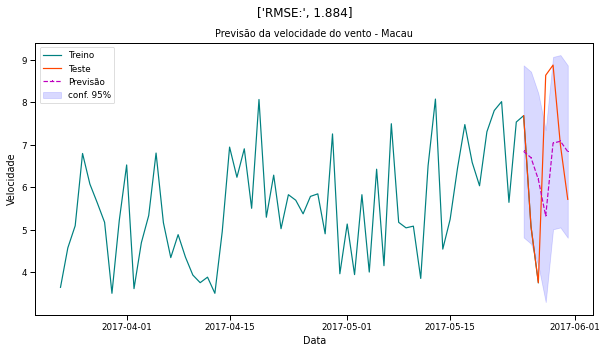

MSE: 3.548957788062797
RMSE: 1.8838677735082143
MAE: 1.6071266041068601
MAPE: 0.2594278426205864


In [ ]:
plot_prediction(train, r_test, conf_m, conf_M, 4830)

> ORDER(1,0,0)

In [ ]:
order = (1,0,0)
r_test,conf_m, conf_M = prediction(df['Velocidade'],order,7)

            Velocidade  predictions_wf
Data                                  
2017-05-25        7.69        6.704173
2017-05-26        5.08        6.802111
2017-05-27        3.76        5.109987
2017-05-28        8.64        4.254593
2017-05-29        8.88        7.414885
2017-05-30        7.00        7.572243
2017-05-31        5.72        6.354062


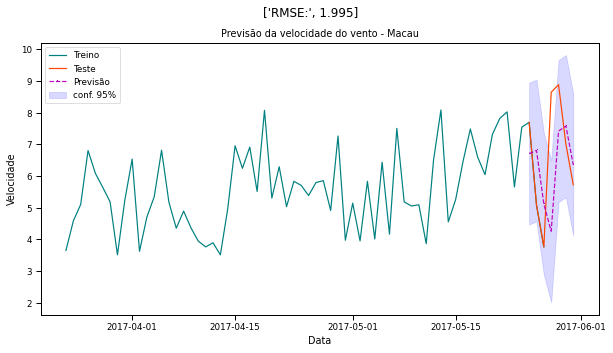

MSE: 3.9811198746947274
RMSE: 1.9952743858163287
MAE: 1.587821593312716
MAPE: 0.29544327319384417


In [ ]:
plot_prediction(train, r_test, conf_m, conf_M, 4830)

> ORDER(0,0,1)

In [ ]:
order = (0,0,1)
r_test,conf_m, conf_M = prediction(df['Velocidade'],order,7)

            Velocidade  predictions_wf
Data                                  
2017-05-25        7.69        6.361390
2017-05-26        5.08        5.779848
2017-05-27        3.76        4.840718
2017-05-28        8.64        4.663995
2017-05-29        8.88        7.006126
2017-05-30        7.00        6.033585
2017-05-31        5.72        5.614348


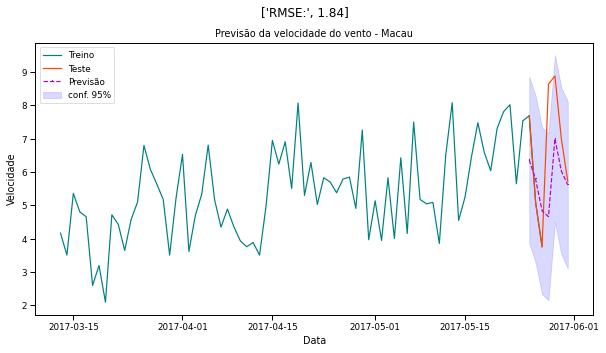

MSE: 3.3840124949191477
RMSE: 1.8395685621686264
MAE: 1.4330175466730946
MAPE: 0.26459108315812424


In [ ]:
plot_prediction(train, r_test, conf_m, conf_M,4820)